In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange, repeat
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-07-15 11:53:16.529657: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 11:53:16.583135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 11:53:18.379271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tqdm.auto import tqdm

In [3]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

In [4]:
import jax
from jax import random, numpy as jnp
import flax
from flax.training import train_state
from flax import linen as nn
import optax
import wandb

In [5]:
# dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_train = KADIK10K("/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K/")
# dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
dst_train = TID2008("/media/disk/vista/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
dst_val = TID2013("/media/disk/vista/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/databases/IQA/TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/databases/IQA/TID/TID2013/", exclude_imgs=[25])

In [6]:
config_ = {
    "BATCH_SIZE": 32,
    "SEED": 42,
}
config_ = ConfigDict(config_)
config_

BATCH_SIZE: 32
SEED: 42

In [7]:
dst_train_rdy = dst_train.dataset.shuffle(buffer_size=100,
                                      reshuffle_each_iteration=True,
                                      seed=config_.SEED)\
                                 .batch(config_.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config_.BATCH_SIZE, drop_remainder=True)

## Load the models

In [8]:
id = "lz4pvm3y"
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_v15/{id}")
config = ConfigDict(prev_run.config["_fields"])
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

In [9]:
class ChromaFreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between gamma_fuencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()
    n_scales: Sequence[int] = jnp.array([4, 2, 2], dtype=jnp.int32)
    n_orientations: Sequence[int] = jnp.array([8, 8, 8], dtype=jnp.int32)

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):

        gamma_f_a = self.param("gamma_f_a",
                             k_array(1/0.4, arr=jnp.array([2.,4.,8.,16.])),
                             (self.n_scales[0],))
        gamma_theta_a = self.param("gamma_theta_a",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[0],))
                                 (8,))

        gamma_f_t = self.param("gamma_f_t",
                             k_array(1/0.4, arr=jnp.array([3.,6.])),
                             (self.n_scales[1],))
        gamma_theta_t = self.param("gamma_theta_t",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[1],))
                                 (8,))
        
        gamma_f_d = self.param("gamma_f_d",
                             k_array(1/0.4, arr=jnp.array([3.,6.])),
                             (self.n_scales[2],))
        gamma_theta_d = self.param("gamma_theta_d",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[2],))
                                 (8,))

        H_cc = self.param("H_cc",
                          nn.initializers.ones_init(),
                          (3,3))

        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)

        ## Repeat gammas
        gamma_f = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_f = jnp.tile(gamma_f, reps=2)
        gamma_theta = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_theta = jnp.tile(gamma_theta, reps=2)

        ## Repeating
        cc = jnp.array([0,1,2])
        cc = jnp.repeat(cc, repeats=jnp.array([64,32,32]), total_repeat_length=len(fmean))

        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None,0,None,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, cc, cc, H_cc, 1)
        kernel = kernel[None,None,:,:]

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, c_1, c_2, H_cc, A=1):
        return H_cc[c_1,c_2]*A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [10]:
class GDNSpatioChromaFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = ChromaFreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return self.param("B", nn.initializers.ones_init(), (outputs.shape[-1],))*inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [11]:
class GaborLayerGammaHumanLike_(nn.Module):
    """Parametric Gabor layer with particular initialization."""
    n_scales: Sequence[int] # [A, T, D]
    n_orientations: Sequence[int] # [A, T, D]

    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1

    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    phase = jnp.array([0., jnp.pi/2.])

    normalize_prob: bool = True
    normalize_energy: bool = False
    zero_mean: bool = False
    train_A: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 return_freq=False,
                 return_theta=False,
                 ):
        total_scales = jnp.sum(jnp.array(self.n_scales))
        total_orientations = jnp.sum(jnp.array(self.n_orientations))
        features = jnp.sum(jnp.array([s*o*len(self.phase) for s, o in zip(self.n_scales, self.n_orientations)]))

        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], features))
        freq_a = self.param("freq_a",
                           freq_scales_init(n_scales=self.n_scales[0], fs=self.fs),
                           (self.n_scales[0],))
        gammax_a = self.param("gammax_a",
                           k_array(k=0.4, arr=1/(freq_a**0.8)),
                           (self.n_scales[0],))
        gammay_a = self.param("gammay_a",
                            equal_to(gammax_a*0.8),
                            (self.n_scales[0],))
        theta_a = self.param("theta_a",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[0]),
                           (self.n_orientations[0],))
        sigma_theta_a = self.param("sigma_theta_a",
                                  equal_to(theta_a),
                                  (self.n_orientations[0],))

        freq_t = self.param("freq_t",
                           freq_scales_init(n_scales=self.n_scales[1], fs=self.fs),
                           (self.n_scales[1],))
        gammax_t = self.param("gammax_t",
                           k_array(k=0.4, arr=1/(freq_t**0.8)),
                           (self.n_scales[1],))
        gammay_t = self.param("gammay_t",
                            equal_to(gammax_t*0.8),
                            (self.n_scales[1],))
        theta_t = self.param("theta_t",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[1]),
                           (self.n_orientations[1],))
        sigma_theta_t = self.param("sigma_theta_t",
                                  equal_to(theta_t),
                                  (self.n_orientations[1],))

        freq_d = self.param("freq_d",
                           freq_scales_init(n_scales=self.n_scales[2], fs=self.fs),
                           (self.n_scales[2],))
        gammax_d = self.param("gammax_d",
                           k_array(k=0.4, arr=1/(freq_d**0.8)),
                           (self.n_scales[2],))
        gammay_d = self.param("gammay_d",
                            equal_to(gammax_d*0.8),
                            (self.n_scales[2],))
        theta_d = self.param("theta_d",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[2]),
                           (self.n_orientations[2],))
        sigma_theta_d = self.param("sigma_theta_d",
                                  equal_to(theta_d),
                                  (self.n_orientations[2],))

        # A = self.param("A",
        #                nn.initializers.ones_init(),
        #                (inputs.shape[-1], features)) if self.train_A else jnp.ones(shape=(inputs.shape[-1], features))
        A = self.param("A",
                       nn.initializers.ones_init(),
                       (inputs.shape[-1], 128))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (features,))
        else: bias = 0.

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            ## A
            kernel_a = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_a, gammay_a, freq_a, theta_a, sigma_theta_a, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_a = rearrange(kernel_a, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_a = repeat(kernel_a, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_a.shape[-1])

            ## T
            kernel_t = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_t, gammay_t, freq_t, theta_t, sigma_theta_t, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_t = rearrange(kernel_t, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_t = repeat(kernel_t, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_t.shape[-1])

            ## D
            kernel_d = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_d, gammay_d, freq_d, theta_d, sigma_theta_d, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_d = rearrange(kernel_d, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_d = repeat(kernel_d, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_d.shape[-1])

            ## Concat all of them
            kernel = jnp.concatenate([kernel_a, kernel_t, kernel_d], axis=-1)
            kernel = kernel * A[None,None,:,:]
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        fmean = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        fmean = jnp.tile(fmean, reps=2)
        theta_mean = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        theta_mean = jnp.tile(theta_mean, reps=2)

        if not had_batch: outputs = outputs[0]
        if return_freq and return_theta:
            return outputs + bias, fmean, theta_mean 
        elif return_freq and not return_theta:
            return outputs + bias, fmean
        elif not return_freq and return_theta:
            return outputs + bias, theta_mean
        else:
            return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, gammax, gammay, freq, theta, sigma_theta, phase, A=1, normalize_prob=True, normalize_energy=False, zero_mean=False):
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        gamma_vector = jnp.array([gammax, gammay])
        inv_cov_matrix = jnp.diag(gamma_vector)**2
        # det_cov_matrix = 1/jnp.linalg.det(cov_matrix)
        # # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        # A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        A_norm = 1.
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ inv_cov_matrix @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        g = jnp.where(zero_mean, g - g.mean(), g)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,None,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], self.phase, 1, self.normalize_prob, self.normalize_energy)
        # kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
        kernel = rearrange(kernel, "rots fs sigmas kx ky -> kx ky (rots fs sigmas)")
        kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=c_in, c_out=kernel.shape[-1])
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [12]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if config.USE_GAMMA: outputs = GDNGamma()(inputs)
        else: outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        # outputs, fmean, theta_mean = GaborLayerGamma_(n_scales=4+2+2, n_orientations=8*3, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        outputs, fmean, theta_mean = GaborLayerGammaHumanLike_(n_scales=[4,2,2], n_orientations=[8,8,8], kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioChromaFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

In [13]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

In [14]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

In [15]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

In [16]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [17]:
import flax

In [18]:
def check_trainable(path):
    if not config.A_GDNSPATIOFREQORIENT:
        if ("GDNSpatioChromaFreqOrient_0" in path) and ("A" in path):
            return True
    if "Color" in path:
        if not config.TRAIN_JH:
            return True
    if "CenterSurroundLogSigmaK_0" in path:
        if not config.TRAIN_CS:
            return True
    if "Gabor" in "".join(path):
        if not config.TRAIN_GABOR:
            return True
    if "GDNSpatioChromaFreqOrient_0" not in path and config.TRAIN_ONLY_LAST_GDN:
        return True
    return False

In [19]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [20]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [21]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [22]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [23]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [24]:
# state1 = orbax_checkpointer.restore(f"{prev_run.dir}/model-0", item=state)
# state2 = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)
state1 = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)
state2 = orbax_checkpointer.restore(f"{prev_run.dir}/model-final", item=state)
# state = orbax_checkpointer.restore(f"{prev_run.dir}/model-0", item=state)

## Extract the weights as a vector

In [25]:
def extract_weights(params):
    weights_, structs = jax.tree_util.tree_flatten(params)
    weights, shapes = [], []
    for w in weights_:
        weights.append(w.flatten())
        shapes.append(w.shape)
    return jnp.concatenate(weights), shapes, structs

In [26]:
w1, s1 = jax.tree_util.tree_flatten(state1.params)

In [27]:
w1, s1, st1 = extract_weights(state1.params)
w2, s2, st2 = extract_weights(state2.params)

In [28]:
def prepare_params(weights, shapes, struct):
    ws = []
    n_w_ = 0
    for s in shapes:
        n_w = jnp.prod(jnp.array(s))
        w_ = weights[n_w_:n_w_+n_w].reshape(s)
        n_w_ += n_w
        ws.append(w_)
    return jax.tree_util.tree_unflatten(struct, ws)

In [29]:
def poly_chain(t, theta, w1, w2):
    return jnp.where(t <= 0.5, 2*(t*theta + (0.5-t)*w1), 2*((t-0.5)*w2 + (1-t)*theta))
    # if t <= 0.5:
    #     return 2*(t*theta + (0.5-t)*w1)
    # elif t <= 1:
    #     return 2*((t-0.5)*w2 + (1-t)*theta)

In [30]:
def bezier_curve(t, theta, w1, w2):
    return ((1-t)**2)*w1 + 2*t*(1-t)*theta + (t**2)*w2

In [31]:
state_theta = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx=optax.sgd(learning_rate=3e-4), input_shape=(1,384,512,3))
state_theta = state_theta.replace(params=clip_layer(state_theta.params, "GDN", a_min=0))

In [32]:
def apply_curve(t, params_theta, params1, params2):
    # return jax.tree_util.tree_map(lambda theta, w1, w2: poly_chain(t=t, theta=theta, w1=w1, w2=w2), params_theta, params1, params2)
    return jax.tree_util.tree_map(lambda theta, w1, w2: bezier_curve(t=t, theta=theta, w1=w1, w2=w2), params_theta, params1, params2)

In [33]:
def l2_regularization(params):
    return jnp.mean(jnp.concatenate([w.flatten() for w in jax.tree_util.tree_leaves(params)]))

In [34]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [ ]:
N_ITERS = 20
BATCH_SIZE = 4
key = random.PRNGKey(42)
state_theta = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx=optax.sgd(learning_rate=3e-4), input_shape=(1,384,512,3))
state_theta = state_theta.replace(params=clip_layer(state_theta.params, "GDN", a_min=0))
losses = []

for n in tqdm(range(N_ITERS)):
    ## 1. Sample a value of t
    t = random.uniform(key, shape=(BATCH_SIZE,), minval=0., maxval=1.)
    key, _ = random.split(key)

    @jax.jit
    def train_step(state_theta, batch):
        def loss_fn(theta_params):
            ## 2. Obtain new weights
            predicted_weights_ = jax.vmap(apply_curve, in_axes=(0,None,None,None))(t, theta_params, state1.params, state2.params)

            ## 3. Calculate the loss with the new weights
            img, img_dist, mos = batch
            img_pred, _ = jax.vmap(lambda params, x: state_theta.apply_fn({"params": params, **state_theta.state}, x, train=True, mutable=list(state_theta.state.keys())), in_axes=(0,None))(predicted_weights_, img)
            img_dist_pred, _ = jax.vmap(lambda params, x: state_theta.apply_fn({"params": params, **state_theta.state}, x, train=True, mutable=list(state_theta.state.keys())), in_axes=(0,None))(predicted_weights_, img_dist)
            dist = ((img_pred - img_dist_pred)**2).sum(axis=(2,3,4))**(1/2)
            losses = jax.vmap(pearson_correlation, in_axes=(0,None))(dist, mos)
            # jax.debug.print(f"{img_pred.shape} | {img_dist_pred.shape} | {dist.shape} | {losses.shape}")
            return losses.mean() #+ 1.*l2_regularization(theta_params)

        ## 4. Calculate the gradient of the loss w.r.t. theta to optimize the curve
        loss, grads = jax.value_and_grad(loss_fn)(state_theta.params)
        state_theta = state_theta.apply_gradients(grads=grads)
        return state_theta, loss

    losses_ = []
    for batch in dst_train_rdy.as_numpy_iterator():
        state_theta, loss = train_step(state_theta, batch)
        losses_.append(jax.device_put(loss, jax.devices("cpu")[0]))
        # break
    losses.append(jnp.mean(jnp.array(losses_)))
    print(f"Epoch {n} -> Loss: {losses[-1]}")
    # break

In [ ]:
# state_theta = orbax_checkpointer.restore("theta", item=state_theta)
orbax_checkpointer.save("theta-best-final-2", item=state_theta)
# orbax_checkpointer.save("theta-0-best", item=state_theta)

In [ ]:
# state_theta = orbax_checkpointer.restore("theta", item=state_theta)
# state_theta = orbax_checkpointer.restore("theta-best-final", item=state_theta)
# orbax_checkpointer.save("theta-0-best", item=state_theta)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def evaluate_params(params, dst):
    dists, moses = [], []
    for batch in dst.as_numpy_iterator():
        img, img_dist, mos = batch

        def loss_fn(params):
            # print(jax.tree_util.tree_map(lambda x: x.shape, params))
            img_pred, _ = state_theta.apply_fn({"params": params, **state_theta.state}, img, train=True, mutable=list(state_theta.state.keys()))
            img_dist_pred, _ = state_theta.apply_fn({"params": params, **state_theta.state}, img_dist, train=True, mutable=list(state_theta.state.keys()))
            dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
            return dist

        dist_ = loss_fn(params)
        dists.extend(dist_)
        moses.extend(mos)
        # break
    dists = jnp.array(dists)
    moses = jnp.array(moses)
    return pearson_correlation(dists, moses)

In [ ]:
def plot_curve(state_theta, state1, state2):
    t = jnp.linspace(0., 1., num=50)
    predicted_weights_ = jax.vmap(apply_curve, in_axes=(0,None,None,None))(t, state_theta.params, state1.params, state2.params)
    losses = jax.vmap(evaluate_params, in_axes=(0,None))(predicted_weights_, dst_train_rdy.unbatch().batch(4))
    # losses = jax.vmap(optax.softmax_cross_entropy_with_integer_labels, in_axes=(0,None), out_axes=0)(logits, y)[0]
    fig, axes = plt.subplots(1,2, figsize=(9,4))
    axes[0].plot(t, losses)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("t")
    # axes[1].plot(t, accs)
    # axes[1].set_ylabel("Accuracy")
    # axes[1].set_xlabel("t")

2024-07-15 11:01:29.598340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1632]
	 [[{{node Placeholder/_0}}]]


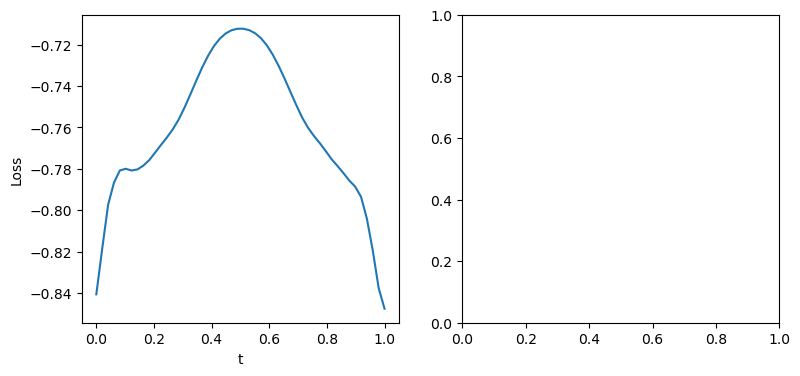

In [ ]:
plot_curve(state_theta, state1, state2)
plt.show()

In [ ]:
def plot_segment(state_theta, state1, state2):
    def segment(t, theta, w1, w2): return jax.tree_util.tree_map(lambda theta, w1, w2: (1-t)*w1 + t*w2, theta, w1, w2)
    t = jnp.linspace(0., 1., num=50)
    predicted_weights_ = jax.vmap(segment, in_axes=(0,None,None,None))(t, state_theta.params, state1.params, state2.params)
    losses= jax.vmap(evaluate_params, in_axes=(0,None))(predicted_weights_, dst_train_rdy.unbatch().batch(4))
    fig, axes = plt.subplots(1,2, figsize=(9,4))
    axes[0].plot(t, losses)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("t")
    # axes[1].plot(t, accs)
    # axes[1].set_ylabel("Accuracy")
    # axes[1].set_xlabel("t")
    plt.suptitle("Segment")

2024-07-15 11:13:44.247505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1632]
	 [[{{node Placeholder/_1}}]]


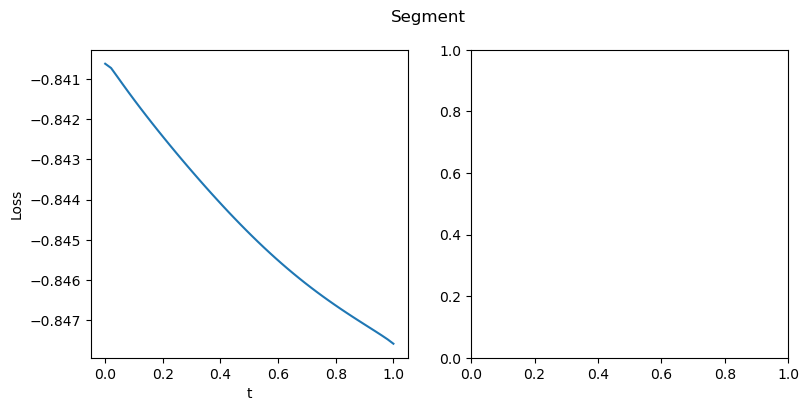

In [ ]:
plot_segment(state_theta, state1, state2)
plt.show()